# SE(2) Theory

We will consider the Lie Group SE(2):

$$X = \begin{bmatrix}
    R & p \\
    & 1                   
\end{bmatrix}$$
where $R \in SO(2)$, $p \in \mathbb{R}^2$

This is the Special Euclidean group of 2 dimensions. Special indicates that all matrices have dimension 1. The Special Euclidean group is the semi direct product of $SO(2)$ and $\mathbb{R}^2$.

The corresponding Lie Algebra se(2) is:

$$x = \begin{bmatrix}
    [\omega] & v \\
    & 0                   
\end{bmatrix}$$
where $\omega = -\omega^T$, $v \in \mathbb{R}^2$

# JAX Install
This installs jax for graphics card acceleration. See instructions here: https://github.com/google/jax#installation

In [1]:
!pip install --upgrade pip
!pip install --upgrade "jax[cuda101]" -f https://storage.googleapis.com/jax-releases/jax_releases.html
!conda install -y slycot

Looking in links: https://storage.googleapis.com/jax-releases/jax_releases.html
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



# Lie Group Code

In [2]:
from jax import numpy as np
from jax import jit
import jax

# you can set gpu or cpu here
#jax.config.update('jax_platform_name', 'gpu')


def check_shape(a, shape):
    if np.shape(a) != shape:
        raise IOError(str(np.shape(a)) + '!=' + str(shape))


def wrap(x):
    return np.where(np.abs(x) >= np.pi, (x + np.pi) % (2 * np.pi) - np.pi, x)


class LieGroup:
    
    def __repr__(self):
        return repr(self.matrix)

    def __mul__(self, other):
        return NotImplementedError('')

    
class LieAlgebra:
    
    def __repr__(self):
        return repr(self.wedge)

    def __mul__(self, other):
        return NotImplementedError('')


class Vector:
    
    def __repr__(self):
        return repr(self.matrix)

    def __mul__(self, other):
        return NotImplementedError('')


class R2(Vector):
    
    def __init__(self, x, y):
        self.x = np.reshape(x, ())
        self.y = np.reshape(y, ())
    
    @property
    def matrix(self):
        return np.array([[self.x], [self.y]])

    def __neg__(self):
        return R2(x=-self.x, y=-self.y)
    
    def __add__(self, other):
        return R2(x=self.x + other.x, y=self.y + other.y)

    @classmethod
    def from_matrix(cls, a):
        return cls(x=a[0], y=a[1])

    
class so2(LieAlgebra):
    
    def __init__(self, theta):
        self.theta = np.reshape(wrap(theta), ())
    
    @property
    def wedge(self):
        return np.array([
            [0, -self.theta],
            [self.theta, 0]
        ])
    
    @property
    def vee(self):
        return np.array([self.theta])

    @property
    def exp(self):
        return SO2(theta=self.theta)
    

class SO2(LieGroup):
    
    def __init__(self, theta):
        self.theta = np.reshape(wrap(theta), ())

    @property
    def inv(self):
        return SO2(theta=-self.theta)

    @property
    def matrix(self):
        return np.array([
            [np.cos(self.theta), -np.sin(self.theta)],
            [np.sin(self.theta), np.cos(self.theta)]
        ])
    
    @property
    def params(self):
        return np.array([self.theta])

    @property
    def log(self):
        return so2(self.theta)
    
    @classmethod
    def from_matrix(cls, a):
        check_shape(a, (2, 2))
        return cls(theta=np.arctan2(a[1, 0], a[0, 0]))

    def __matmul__(self, other):
        if isinstance(other, R2):
            return R2.from_matrix(self.matrix@other.matrix)
        elif isinstance(other, SO2):
            return SO2(theta=self.theta + other.theta)


class se2(LieAlgebra):
    
    def __init__(self, x, y, theta):
        self.x = np.reshape(x, ())
        self.y = np.reshape(y, ())
        self.theta = np.reshape(theta, ())

    def __neg__(self):
        return se2(-self.x, -self.y, -self.theta)

    @property
    def wedge(self):
        return np.array([
            [0, -self.theta, self.x],
            [self.theta, 0, self.y],
            [0, 0, 0]
        ])
    

    def __add__(self, other):
        return se2(x=self.x + other.x, y=self.y + other.y, theta=self.theta + other.theta)
    
    def __sub__(self, other):
        return se2(x=self.x - other.x, y=self.y - other.y, theta=self.theta - other.theta)
    
    @property
    def vee(self):
        return np.array([self.x, self.y, self.theta])
    
    @classmethod
    def from_vector(cls, v):
        return cls(x=v[0], y=v[1], theta=v[2])
        
    def from_matrix(self, a):
        check_shape(a, (3, 3))
        return se2(x=a[0, 2], y=a[1, 2], theta=a[1, 0])

    @property
    def ad_matrix(self):
        x, y, theta = self.x, self.y, self.theta
        return np.array([
            [0, -theta, y],
            [theta, 0, -x],
            [0, 0, 0]
        ])

    def ad(self, other):
        return se2.from_vector(self.ad_matrix@other.vee)

    @property
    def exp(self):
        theta = self.theta
        a = np.where(np.abs(theta) < 1e-3, 1 - theta**2/6 + theta**4/12, np.sin(theta)/theta)
        b = np.where(np.abs(theta) < 1e-3, theta/2 - theta**3/24 + theta**5/720, (1 - np.cos(theta))/theta)
        V = np.array([[a, -b], [b, a]])
        p = V@np.array([self.x, self.y])
        return SE2(x=p[0], y=p[1], theta=self.theta)

    def __rmul__(self, scalar):
        s = np.reshape(scalar, ())
        return se2(x=self.x*s, y=self.y*s, theta=self.theta*s)


class SE2(LieGroup):
    
    def __init__(self, x, y, theta):
        self.x = np.reshape(x, ())
        self.y = np.reshape(y, ())
        self.theta = np.reshape(wrap(theta), ())
        
    @property
    def params(self):
        return np.array([self.x, self.y, self.theta])
    
    @property
    def matrix(self):
        x, y, theta = self.x, self.y, self.theta
        return np.array([
            [np.cos(theta), -np.sin(theta), x],
            [np.sin(theta), np.cos(theta), y],
            [0, 0, 1]
        ])

    @property
    def R(self):
        return SO2(theta=self.theta)

    @property
    def p(self):
        return R2(x=self.x, y=self.y)
    
    @property
    def inv(self):
        p = -(self.R.inv@self.p)
        return SE2(x=p.x, y=p.y, theta=-self.theta)

    def __matmul__(self, other):
        p = self.R@other.p + self.p
        return SE2(x=p.x, y=p.y, theta=self.theta + other.theta)

    @classmethod
    def from_matrix(cls, a):
        check_shape(a, (3, 3))
        return SE2(theta=np.arctan2(a[1, 0], a[0, 0]),
                   x=a[0, 2], y=a[1, 2])

    @property
    def Ad_matrix(self):
        x, y, theta = self.x, self.y, self.theta
        return np.array([
            [np.cos(theta), -np.sin(theta), y],
            [np.sin(theta), np.cos(theta), -x],
            [0, 0, 1]
        ])
    
    def Ad(self, v):
        v2 = self.Ad_matrix@np.array([v.x, v.y, v.theta])
        return se2(x=v2[0], y=v2[1], theta=v2[2])

    @property
    def log(self):
        x, y, theta = self.x, self.y, self.theta
        a = np.where(np.abs(theta) < 1e-3, 1 - theta**2/6 + theta**4/12, np.sin(theta)/theta)
        b = np.where(np.abs(theta) < 1e-3, theta/2 - theta**3/24 + theta**5/720, (1 - np.cos(theta))/theta)
        V_inv = np.array([
            [a, b],
            [-b, a]
        ])/(a**2 + b**2)
        p = V_inv@np.array([x, y])
        return se2(x=p[0], y=p[1], theta=theta)     

# Solve for Trajectory

TODO

# Solve for Control Gain

Find gain for forward driving at velocity 1 m/s.

In [3]:
import control
def solve_control_gain():
    A = -se2(x=1, y=0, theta=0).ad_matrix
    B = np.array([[1, 0], [0, 0], [0, 1]])
    Q = 1*np.eye(3)  # penalize state
    R = 1*np.eye(2)  # penalize input
    K, _, _ = control.lqr(A, B, Q, R)
    K = K/np.max(K)  # rescale K
    return K

K = solve_control_gain()
K

DeviceArray([[0.57735026, 0.        , 0.        ],
             [0.        , 0.57735026, 0.99999994]], dtype=float32)

# Simulation

simulation complete


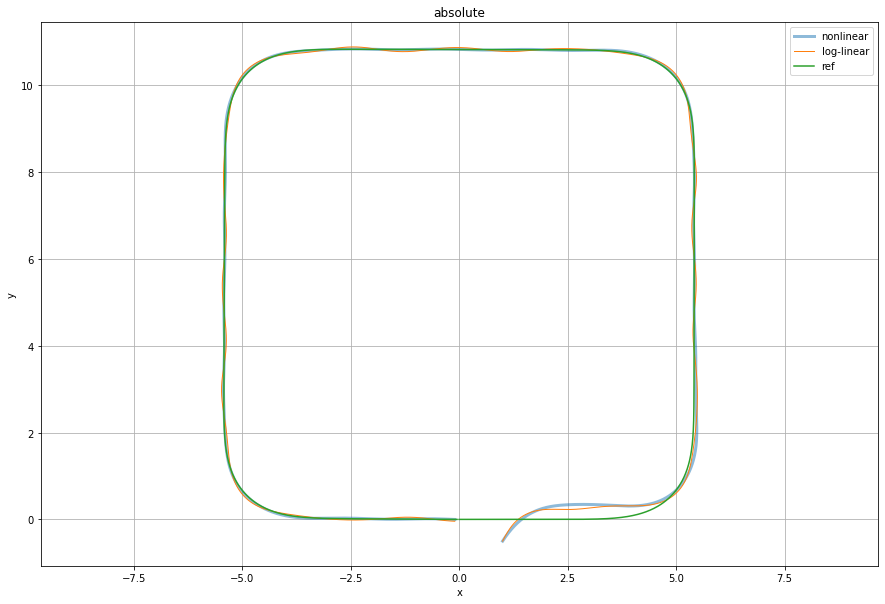

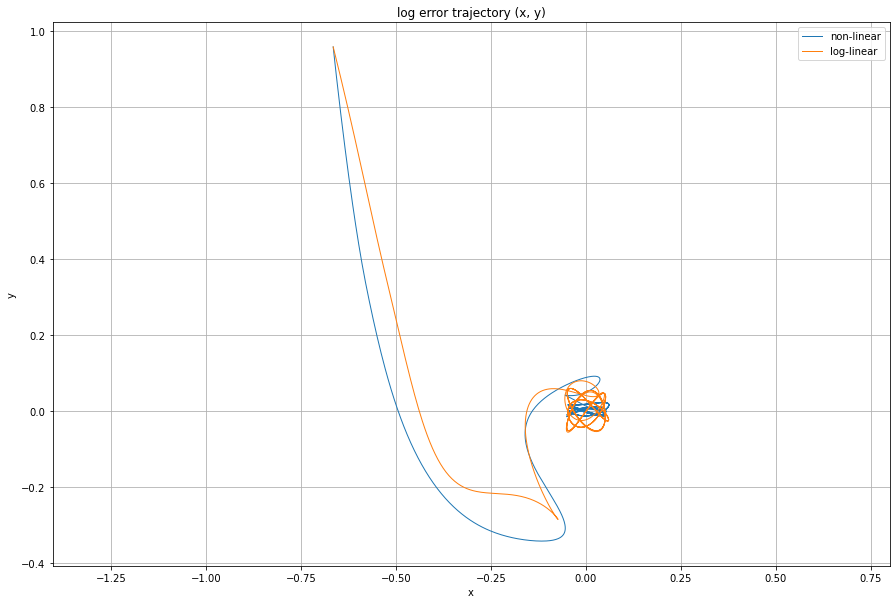

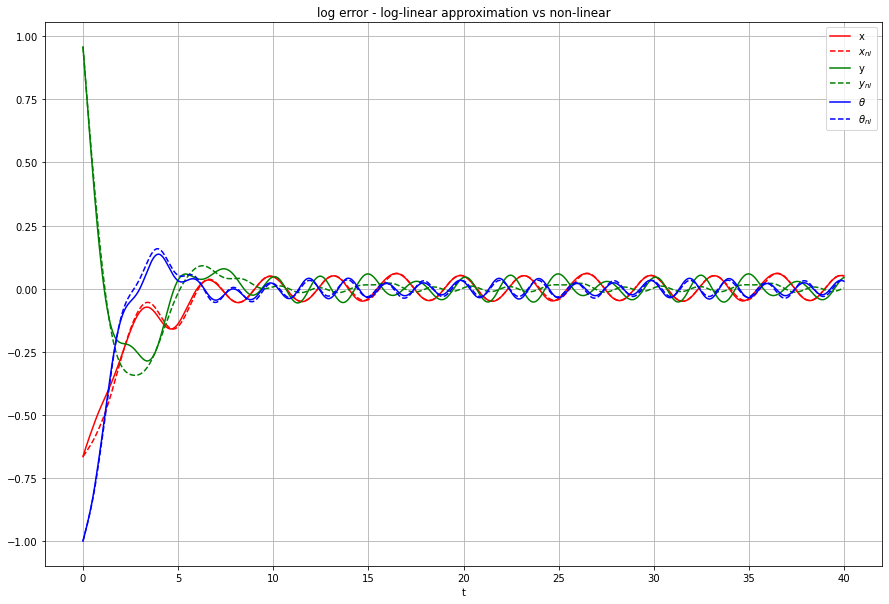

In [4]:
import scipy.integrate
import matplotlib.pyplot as plt

# function to compute exp of log error
def compute_exp_log_err(e_x, e_y, e_theta, x_r, y_r, theta_r):
    return (SE2(x=x_r, y=y_r, theta=theta_r)@((se2(x=e_x, y=e_y, theta=e_theta).exp).inv)).params

jit_compute_exp_log_err = jit(compute_exp_log_err)

# function to compute log of error using group elements
def compute_log_err(x, y, theta, x_r, y_r, theta_r):
    return (SE2(x=x, y=y, theta=theta).inv@SE2(x=x_r, y=y_r, theta=theta_r)).log.vee
    
jit_compute_log_err = jit(compute_log_err)

def dynamics(t, y_vect):
    X = SE2(x=y_vect[0], y=y_vect[1], theta=y_vect[2])
    X_r = SE2(x=y_vect[3], y=y_vect[4], theta=y_vect[5])
    
    e = se2(x=y_vect[6], y=y_vect[7], theta=y_vect[8])
    e_nl = (X.inv@X_r).log
    
    # reference input
    v_r = se2(x=1, y=0, theta=0.01087*(1 - np.cos(2*np.pi*t*0.1))**6)
    
    # disturbance
    w = 0.1*se2(x=np.sin(2*np.pi*0.3*t), y=np.sin(2*np.pi*0.4*t), theta=np.sin(2*np.pi*0.5*t))
    
    def control_law(e):
        B = np.array([
            [1, 0],
            [0, 0],
            [0, 1]
        ])
        # saturation
        norm_e = np.linalg.norm(e.vee)
        e_scaled = np.where(norm_e > 1, e.vee/norm_e, e.vee)
        # compute u
        u = se2.from_vector(B@K@e_scaled)
        return v_r + u

    # control law applied to non-linear error
    v_nl = control_law(e_nl) + w
    
    # control law applied to log-linear error
    v = control_law(e) + w
        
    # log error dynamics
    e_dot = -v_r.ad(e) + v_r - v
    
    return [
        # actual
        v_nl.x*np.cos(X.theta),
        v_nl.x*np.sin(X.theta),
        v_nl.theta,
        # reference
        v_r.x*np.cos(X_r.theta),
        v_r.x*np.sin(X_r.theta),
        v_r.theta,
        # log error
        e_dot.x,
        e_dot.y,
        e_dot.theta
    ]
jit_dynamics = jit(dynamics)

def simulate():
    t_vect = np.arange(0, 40, 0.02)  # time vector

    X0 = SE2(x=1, y=-0.5, theta=1)  # initial state
    X0_r = SE2(x=0, y=0, theta=0)  # initial reference state
    x0 = (X0.inv@X0_r).log  # initial log of error

    # solve initial value problem
    res = scipy.integrate.solve_ivp(
        fun=jit_dynamics,
        t_span=[t_vect[0], t_vect[-1]], t_eval=t_vect,
        y0=[X0.x, X0.y, X0.theta,
            X0_r.x, X0_r.y, X0_r.theta,
            x0.x, x0.y, x0.theta], rtol=1e-12, max_step=0.05)
    return res

def plot(res):
    y_vect = res['y']
    x, y, theta, x_r, y_r, theta_r, log_e_x, log_e_y, log_e_theta = [y_vect[i, :] for i in range(len(y_vect))]
    exp_log_err = np.array([ jit_compute_exp_log_err(y[6], y[7], y[8], y[3], y[4], y[5]) for y in y_vect.T]).T
    log_err_check = np.array([ jit_compute_log_err(y[0], y[1], y[2], y[3], y[4], y[5]) for y in y_vect.T]).T

    plt.rcParams['figure.figsize'] = (15, 10)
    
    plt.figure()
    plt.title('absolute')
    plt.grid()
    plt.plot(x, y, label='nonlinear', linewidth=3, alpha=0.5)
    plt.plot(exp_log_err[0, :], exp_log_err[1, :], label='log-linear', linewidth=1)
    plt.plot(x_r, y_r, label='ref')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.axis('equal');

    plt.figure()
    plt.title('log error trajectory (x, y)')
    plt.grid()
    plt.plot(log_err_check[0, :], log_err_check[1, :], label='non-linear', linewidth=1)
    plt.plot(log_e_x, log_e_y, label='log-linear', linewidth=1)
    #plt.plot(exp_log_err[0, :], exp_log_err[1, :], label='exp log error')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal');
    plt.legend()

    plt.figure()
    plt.title('log error - log-linear approximation vs non-linear')
    plt.grid()
    plt.plot(res['t'], log_e_x, 'r-', label='x')
    plt.plot(res['t'], log_err_check[0, :], 'r--', label='$x_{nl}$')
    plt.plot(res['t'], log_e_y, 'g-', label='y')
    plt.plot(res['t'], log_err_check[1, :], 'g--', label='$y_{nl}$')
    plt.plot(res['t'], log_e_theta, 'b-', label='$\\theta$')
    plt.plot(res['t'], log_err_check[2, :], 'b--', label='$\\theta_{nl}$')
    plt.xlabel('t')
    plt.legend()
    return locals()

    
res = simulate()
print('simulation complete')
data = plot(res)